,Text,sentiment
0,A new second spot from ESPN celebrates women a...,1
1,a million times we re probably explaining that...,1
2,Many praised fan favorite Hanyu for always bri...,0
3,Seventeen year old snowboarding sensation Chlo...,0
4,He is man who needs to take responsibility for...,0
5,In Change org petition asked Victoria Secret t...,1
6,Velez suggested that at some point the men cou...,1
7,Obama didn mince words when the discussion tur...,1
8,From the right this view lines up with belief ...,1
9,The announcement follows an email scandal firs...,1


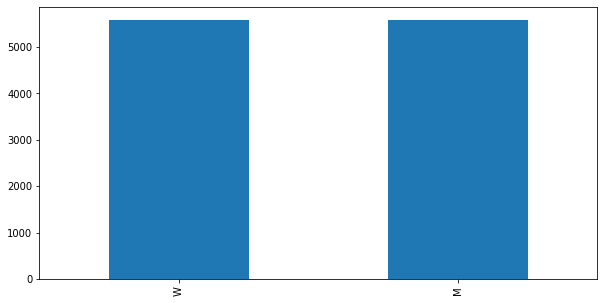

In [3]:
import pandas as pd

df = pd.read_json('../datasets/8_dataset_simple_SM.json')
df = df[df.Text != " "]

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['sentiment'] = df.Gender.apply(lambda x: 0 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df = df.sample(frac=1).reset_index(drop=True)

split = round(len(df)*0.6)
train_data = df[:split]
test_data = df[split:]

split = round(len(train_data)*0.8)
val_data = train_data[split:]
train_data = train_data[:split]

train_data.head(10)

In [4]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import numpy as np
import tensorflow as tf
tokenizer = Tokenizer(oov_token="<OOV>")

vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['Text'])

train_seqs = tokenizer.texts_to_sequences(train_data['Text'])
X_train = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)
val_seqs = tokenizer.texts_to_sequences(val_data['Text'])
X_val = pad_sequences(val_seqs, maxlen=max_length)
test_seqs = tokenizer.texts_to_sequences(test_data['Text'])
X_test = pad_sequences(test_seqs, maxlen=max_length)

y_train = np.array(train_data['sentiment'])
y_val = np.array(val_data['sentiment'])
y_test = np.array(test_data['sentiment'])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

num_epochs = 20
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks =[earlystopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
168/168 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.5007 - val_loss: 0.6930 - val_accuracy: 0.4985
Epoch 2/20
168/168 [==============================] - 1s 5ms/step - loss: 0.6912 - accuracy: 0.5450 - val_

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

<Figure size 432x288 with 0 Axes>

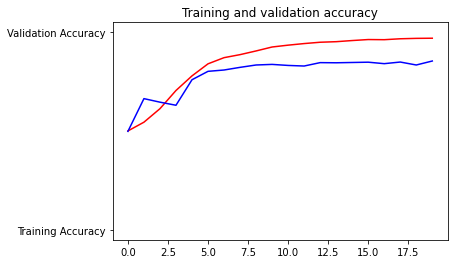

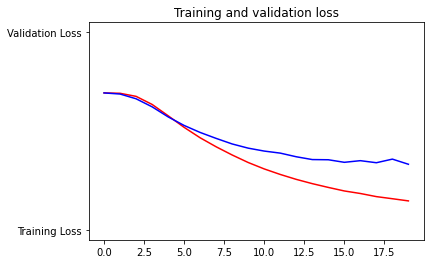

<Figure size 432x288 with 0 Axes>

In [5]:
%load_ext tensorboard
%tensorboard --logdir=./la_logs --port=6006

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [6]:
model.save('keras_simple.h5')

In [7]:
model = tf.keras.models.load_model('keras_simple.h5')

In [8]:
y_pred = model.predict(X_test)
y_pred_binary = []
for x in y_pred:
    y_pred_binary.append(0 if x < 0.5 else 1)

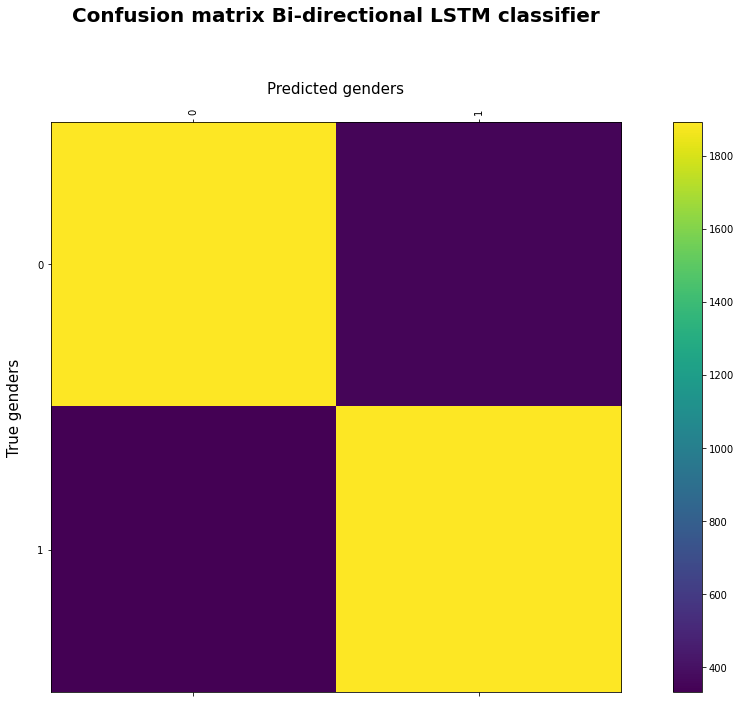

array([[1893,  352],
       [ 331, 1890]], dtype=int64)

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted genders', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True genders', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(2), [0,1], rotation=90)
plt.yticks(range(2), [0,1])
plt.show()
cm

In [10]:
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'W']

report = classification_report(y_test, y_pred_binary, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_4188/1509086957.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.85,0.84,0.85,2245.0
1,W,0.84,0.85,0.85,2221.0
